# Assignment 4 : Structured Illumination and Meshing

---
Please edit the cell below to include your name and student ID #

**name:** Paul Tran

**SID:** 57931045

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera,triangulate
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [60]:
plt.rcParams['figure.figsize']=[15,15] #adjust this as needed to get clearly visible figures

***

# 1. Decoding

Write a function called **decode** that reads in a set of images captured with the camera showing the projected gray code and returns an array which is the same size as the camera image where each element contains the decoded value (0..1023) as well as a binary image (mask) indicating which pixels could be reliably decoded. We will end up calling this function 4 times, once for the horizontal and once for the vertical coordinates in both the left and right cameras. 


## 1.1 Implement [25pts]

Use a for loop to generate the list of image file names to load in. Assume that there are 20 images for the 10 bit gray code.  The images come in pairs where the second is the inverse of the first.  For each pair of images, recover the bit by checking to see that the first image is greater or less than the second.  You should also maintain a seperate binary array (mask) the same size as the images in which you mark "undecodable" pixels for which the absolute difference between the first and second image in the pair is smaller than some user defined threshold.  This will allow us to ignore pixels for which the decoding is likely to fail (e.g., pixels that weren't illuminated by the projector). I used a threshold of 0.02 when reconstructing the scan below. You will want to mark a pixel as bad if any of the 10 bits was undecodeable.

After thresholding the pairs you should have 10 binary images.  You can convert this stack of binary images
into a single "decimal image" by decoding each bit pattern to its corresponding decimal representation.  As
discussed in class, the bits are coded using a graycode rather than a standard binary code so you will need to
do a little work to decode them correctly.

I recommend first converting the 10 bit code from the gray code to standard binary (binary coded decimal) using the algorithm we described in class that successively XORs the bits. Once you have converted to BCD, you can then produce the final decimal value using the standard binary-to-decimal conversion  (i.e., assuming B[0] is the most significant bit then $\sum_{n=0}^9 B[9-n]*2^n$). 

In NumPy you can implement both steps efficiently with a for-loop over the 10 bits and vectorized operations
over the spatial locations. Make sure you are processing the bits in the correct order (i.e. from least-significant to most-significant).


In [61]:
def decode(imprefix,start,threshold):
    """
    Given a sequence of 20 images of a scene showing projected 10 bit gray code, 
    decode the binary sequence into a decimal value in (0,1023) for each pixel.
    Mark those pixels whose code is likely to be incorrect based on the user 
    provided threshold.  Images are assumed to be named "imageprefixN.png" where
    N is a 2 digit index (e.g., "img00.png,img01.png,img02.png...")
 
    Parameters
    ----------
    imprefix : str
       Image name prefix
      
    start : int
       Starting index
       
    threshold : float
       Threshold to determine if a bit is decodeable
       
    Returns
    -------
    code : 2D numpy.array (dtype=float)
        Array the same size as input images with entries in (0..1023)
        
    mask : 2D numpy.array (dtype=logical)
        Array indicating which pixels were correctly decoded based on the threshold
    
    """
    
    # we will assume a 10 bit code
    nbits = 10
    bits = []

    # load in the first image to get the image size
    imname = imprefix + '%02d.png' % start
    im = plt.imread(imname)
    if(im.dtype == np.uint8):
        im = im.astype(np.float32)/256.0
    #convert to grayscale if needed
    if(len(im.shape) > 2):
        im = np.mean(im,axis=2)

    mask = np.ones(im.shape)

    # loop over the 10 bits
    for N in range(start,start+20,2):
        # load in the two images for this bit
        imname0 = imprefix + '%02d.png' % (N)
        imname1 = imprefix + '%02d.png' % (N+1)
        im0 = plt.imread(imname0)
        im1 = plt.imread(imname1)
        if(im0.dtype == np.uint8):
            im0 = im0.astype(np.float32)/256.0
        if(im1.dtype == np.uint8):
            im1 = im1.astype(np.float32)/256.0
        #convert to grayscale if needed
        if(len(im0.shape) > 2):
            im0 = np.mean(im0,axis=2)
        if(len(im1.shape) > 2):
            im1 = np.mean(im1,axis=2)

        bits.append(1*(im0 > im1))

        mask = mask * (1*(abs(im0-im1)>threshold))

    binary = []
    binary.append(bits[0])
    for i in range(nbits-1):
        binary.append(np.logical_xor(binary[i],bits[i+1]))

    code = np.zeros(im.shape)
    for i in range(nbits):
        code += binary[9-i]*(2**i)

    return code,mask

***

## 1.2 Test and Visualize [5pts]

The graycode images which are projected are included in the data sub-directory **gray/**.  This is useful for
debugging your decode function prior to running it on the real scan data since the results should be perfect
(no noise!).

1. Check that your decode function correct decodes the projector data
2. Visualize the results of running your decode function on one of the provided scans


Text(0.5, 1.0, 'Decoding Mask')

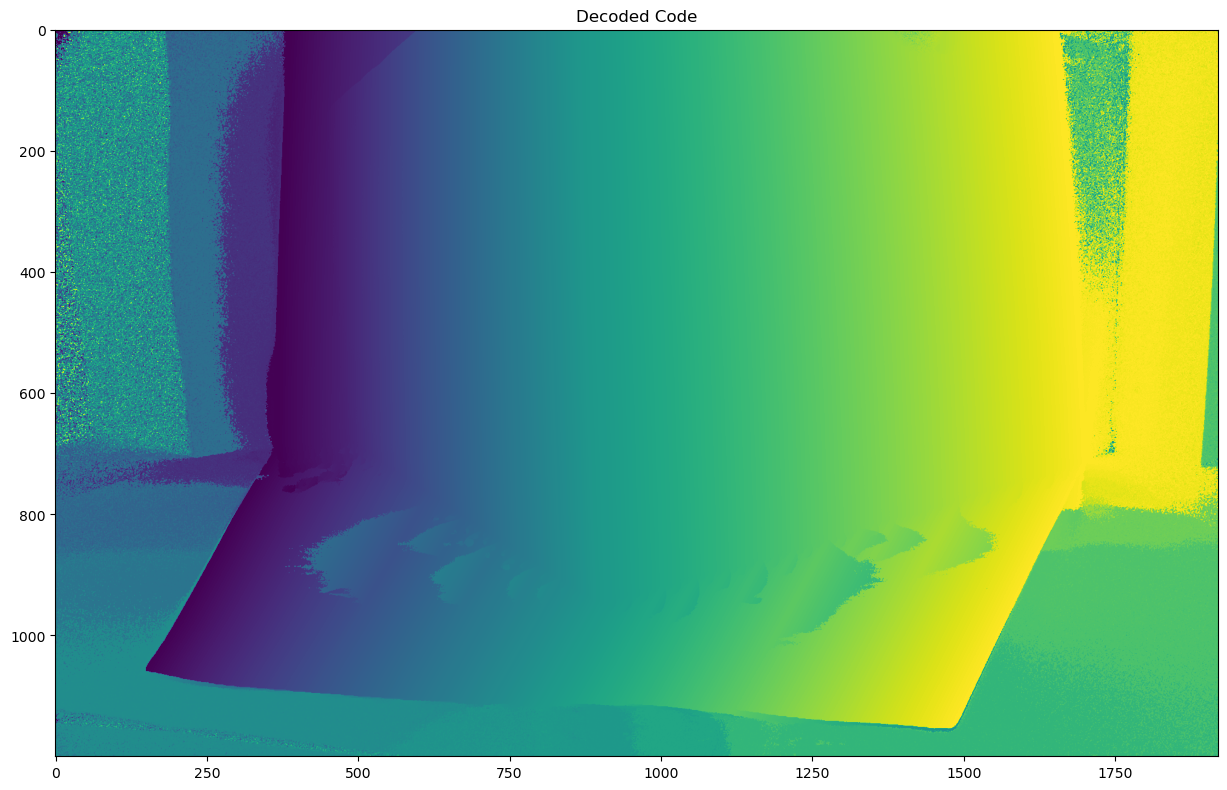

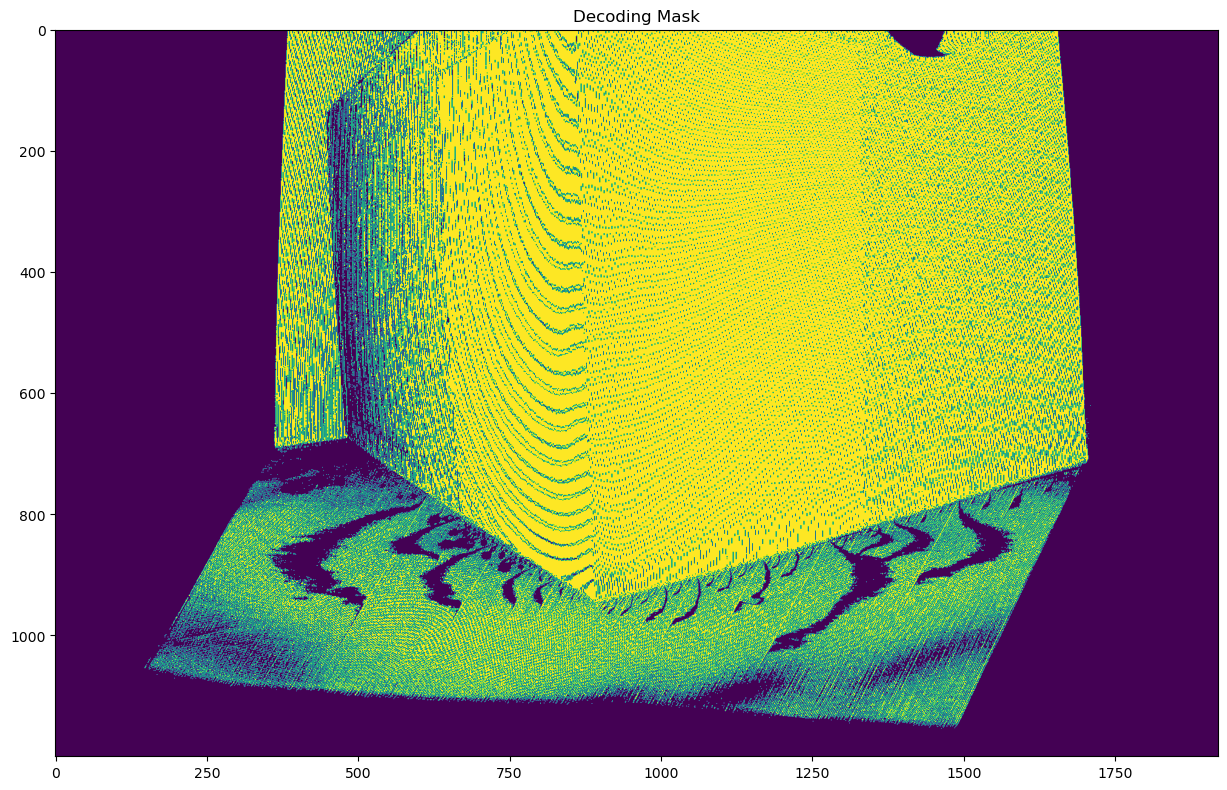

In [62]:
#
# first generate arrays containing the "true" codes projected by 
# the projector
#
# the projector had a resolution of 1280x800 so there are black bars 
# of 128 pixels on either side of our 1024 pixel region

pad = np.zeros((800,128))
hcode,vcode = np.meshgrid(range(1024),range(800))
Htrue = np.concatenate((pad,hcode,pad),axis=1)
Vtrue = np.concatenate((pad,vcode,pad),axis=1)
masktrue = np.concatenate((pad,np.ones((800,1024)),pad),axis=1)

#
# run your decoding on the projector images
#
thresh = 0.0000001  #this data is perfect so we can use a very small threshold

H,Hmask = decode('gray/',0,thresh)
V,Vmask = decode('gray/',20,thresh)

# compare to the known "true" code
assert((H==Htrue).all())
assert((V==Vtrue).all())
assert((Hmask==masktrue).all())
assert((Vmask==masktrue).all())


#
# Visualize results for the first scan and experiment to determine a good threshold
#
threshold = 0.02
code,mask = decode('scan0/frame_C0_',0,threshold)

# display view code and mask as images
plt.figure()
plt.imshow(code)
plt.title('Decoded Code')


plt.figure()
plt.imshow(mask)
plt.title('Decoding Mask')


***
# 2. Reconstruction 

We can now use the decoded pixel ids in order to easily find correspondences between two different camera views and triangulate the resulting points. You can use your own implementation from assignment 2 or import the provided **camutils.py** module as needed to do the triangulation. 

## 2.1 Implementation [25pts]

Write a function called **reconstruct** that takes a set of graycoded images from the pair of cameras and produces a 3D point cloud.  To achieve this:

1. Call your decode function four times to decode the horizontal and vertical images for both the left and right cameras. If you visualize the resulting codes, they should look like the figure below (after masking).  You should combine the horizontal and vertical codes to get a single (20-bit) integer for the left and right cameras.  You should also combine the corresponding binary masks so only pixels with both good horizontal and vertical codes are marked as valid.

2. For each pixel in the left image which was succesfully decoded, find the pixel in the right image with the corresponding code. One way to do this effeciently is using the **numpy.intersect1d** function with *return_indices=True* in order to get indices of matching pixels in the two images.

3. Now that you have corrsponding pixel coordinates in the two images and the camera parameters, use **triangulate** to get the 3D coordinates for this set of pixels. 

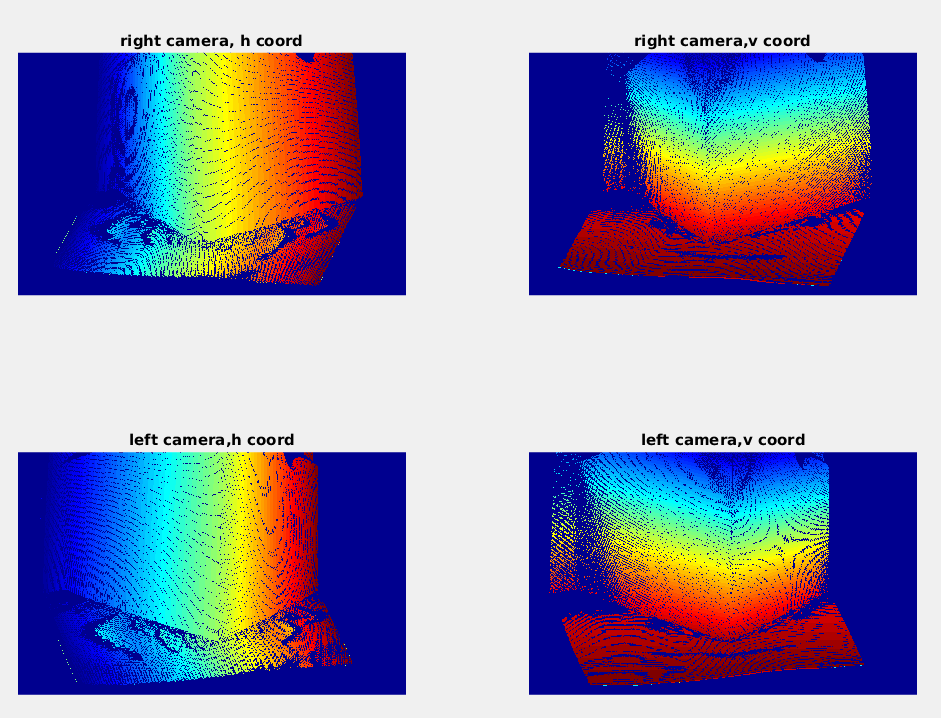

In [63]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR):
    """
    Performing matching and triangulation of points on the surface using structured
    illumination. This function decodes the binary graycode patterns, matches 
    pixels with corresponding codes, and triangulates the result.
    
    The returned arrays include 2D and 3D coordinates of only those pixels which
    were triangulated where pts3[:,i] is the 3D coordinte produced by triangulating
    pts2L[:,i] and pts2R[:,i]

    Parameters
    ----------
    imprefixL, imprefixR : str
        Image prefixes for the coded images from the left and right camera
        
    threshold : float
        Threshold to determine if a bit is decodeable
   
    camL,camR : Camera
        Calibration info for the left and right cameras
        
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)
        The 2D pixel coordinates of the matched pixels in the left and right
        image stored in arrays of shape 2xN
        
    pts3 : 2D numpy.array (dtype=float)
        Triangulated 3D coordinates stored in an array of shape 3xN
        
    """

    # Decode the H and V coordinates for the two views
    Hleft,HmaskL = decode(imprefixL,0,threshold)
    Vleft,VmaskL = decode(imprefixL,20,threshold)
    Hright,HmaskR = decode(imprefixR,0,threshold)
    Vright,VmaskR = decode(imprefixR,20,threshold)

    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    Lmask = HmaskL * VmaskL
    Rmask = HmaskR * VmaskR
    Cleft = (Hleft + 1024*Vleft) * Lmask
    Cright = (Hright + 1024*Vright) * Rmask
    
    # Find the indices of pixels in the left and right code image that 
    # have matching codes. If there are multiple matches, just
    # choose one arbitrarily.
    matchL = np.intersect1d(Cleft,Cright,return_indices=True)[1]
    matchR = np.intersect1d(Cleft,Cright,return_indices=True)[2]
    
    # Let CL and CR be the flattened arrays of codes for the left and right view
    # Suppose you have computed arrays of indices matchL and matchR so that 
    # CL[matchL[i]] == CR[matchR[i]] for all i.  The code below gives one approach
    # to generating the corresponding pixel coordinates for the matched pixels.

    # First generate the 2D pixel coordinates for all pixels in the left and right image

    h, w = Hleft.shape

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    # Now triangulate the points
    pts3 = triangulate(pts2L,camL,pts2R,camR)
    
    
    return pts2L,pts2R,pts3

***

## 2.2 Visualization [5pts]

I've have provided the calibration for the two cameras in the scan0/scan0_calibration.pickle so that you can easily load them in to your code.  Call your **reconstruct** function on the provided image data and visualize the reconstructed 3D points to make sure everything is working. You may want to experiment with adjusting the decoding threshold to get a good number of points without too much noise. 

Please note that at this stage the results are quite noisy so if you plot them, you will probably need to zoom in to see the main object. You can adjust your plot axes to set the extent of the plot axis after displaying the points.  For this scan, axis limits of [-200 400],[-200 300], and [-200 200] in the x,y and z directions repectively should work well.

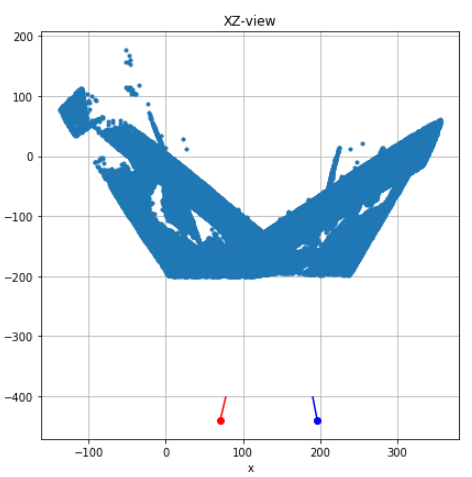

Camera : 
 f=1412 
 c=[[995 582]] 
 R=[[ 0.9885 -0.0185 -0.1504]
 [-0.0018  0.991  -0.1336]
 [ 0.1515  0.1324  0.9796]] 
 t = [[ 196.4  144.5 -440.6]]
Camera : 
 f=1410 
 c=[[986 608]] 
 R=[[ 0.9834 -0.024   0.1797]
 [ 0.0454  0.9922 -0.1157]
 [-0.1756  0.122   0.9769]] 
 t = [[  70.5  148.1 -440.6]]


Text(0, 0.5, 'y')

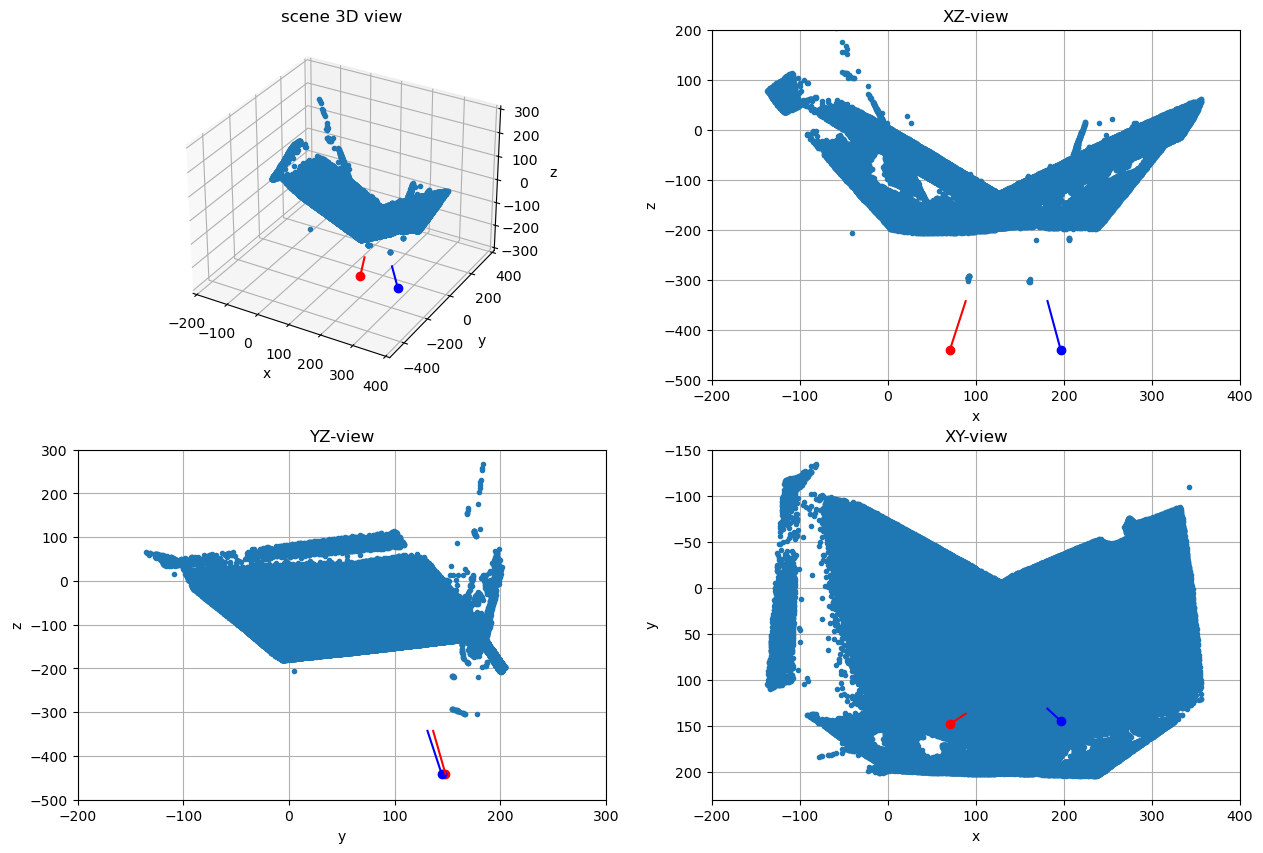

In [64]:
#
# Reconstruct and visualize the results
#
imprefixC0 = "scan0/frame_C0_"
imprefixC1 = "scan0/frame_C1_"
threshold = 0.02

fid = open('scan0/scan0_calibration.pickle','rb')
(camC0,camC1) = pickle.load(fid)
fid.close

camL = camC0
camR = camC1

print(camL)
print(camR)

pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camC0,camC1)

# Add your visualization code here.  As we have done previously it is good to visualize different
# 2D projections XY, XZ, YZ and well as a 3D version

# generate coordinates of a line segment running from the center of the camera to 3 units in front of the camera
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,100]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,100]]).T))

# 3D plot showing cameras and points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
ax.set_xlim3d([-200,400])
ax.set_ylim3d([-500,400])
ax.set_zlim3d([-300,300])
visutils.label_axes(ax)
plt.title('scene 3D view')

# 2D view of the XZ axis
ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.axis([-200, 400, -500, 200])
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

# 2D view of the YZ axis
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.axis([-200, 300, -500, 300])
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

# 2D view of the XY axis
ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.axis([-200, 400, 230, -150])
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')


***

# 3. Meshing

To display the reconstructed scan as a surface, we need to generate triangular faces of the mesh which connect up the points. Write code that takes the output of **reconstruct** and produces a triangulated mesh. Your mesh should be represented by an array of points (vertices) and an array of triplets of point indices (triangular faces).


## 3.1 Implementation [35pts]

**reconstruct** provides us with the set of verticies.  To find the faces of your mesh, we will use the 2D
coordinates of the points as they were visible in the left image (**pts2L**).  Use the function **scipy.spatial.Delaunay** on these 2D coordinates to get the list of triangles.  These faces along with the 3D coordinates of the points provide a description of the surface in 3D.  You can display the resulting surface mesh in using **plot_trisurf** passing it the coordinates in **pts3** and the triangles in **tri** returned by Delaunay that contains the list of triangles.

You will also need to implement some code in your mesh function for pruning out noisy points.  Please
implement the following two ideas:

**(a) Bounding Box Pruning:** The scanned object lies in a bounding box roughly 400mm on a side.  Prune the set of triangulated points to only keep those that are inside this 3D volume.  You will need to experiment to find the best bounding box dimensions along the x,y and z coordinates in order to enclose the surface but exclude as much of the noise points as possible.  Once you have determined a good range, you should drop points in *pts3* that are outside that range.  You should also drop the corresponding 2D points stored in *pts2L* and *pts2R*.  Once you have dropped the points outside the bounding box, you should (re)run **Delaunay** to get a triangulation which only includes the good points.

**(b) Triangle Pruning:**  Remove triangles from the surface mesh that include edges that are longer than a user-defined threshold.  Typically when we have points on the surface, they will be relatively close by so this gives a way to get rid of noisy points off the surface.  After removing mesh triangles with edges that are too long, you will find points that are no-longer connected to any neighbor in the mesh (e.g. they are no longer in any mesh triangle).  Find these points and remove them as well so that the final mesh you produce doesn't include any unreferenced vertices.

Your script should include a user specified parameter **trithresh** which specifies the longest allowed
edge that can appear in the mesh. You should remove any triangles for which the longest edge of the
triangle has a length greater than **trithresh**.  The units of the reconstruction are in mm so the threshold
will be in those same units.  You will need to experiment to determine a good setting.


In [65]:
# Mesh cleanup parameters

from scipy.spatial import Delaunay

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
boxlimits = np.array([-100,400,-500,400,-300,300])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 1

#
# bounding box pruning
#

prune_list = []
for i in range(pts3.shape[1]):
    if pts3[0,i] < boxlimits[0] or pts3[0,i] > boxlimits[1] or pts3[1,i] < boxlimits[2] or pts3[1,i] > boxlimits[3] or pts3[2,i] < boxlimits[4] or pts3[2,i] > boxlimits[5]:
        prune_list.append(i)

pts3 = np.delete(pts3, prune_list, axis=1)
pts2L = np.delete(pts2L, prune_list, axis=1)
pts2R = np.delete(pts2R, prune_list, axis=1)


#
# triangulate the 2D points to get the surface mesh
#

tri = Delaunay(pts2L.T)

#
# triangle pruning
#

prune_points = []
prune_triangles = []

for i in range(tri.simplices.shape[0]):
    p1 = pts3[:,tri.simplices[i,0]]
    p2 = pts3[:,tri.simplices[i,1]]
    p3 = pts3[:,tri.simplices[i,2]]
    if np.linalg.norm(p1-p2) > trithresh or np.linalg.norm(p2-p3) > trithresh or np.linalg.norm(p3-p1) > trithresh:
        prune_triangles.append(i)
        prune_points.append(tri.simplices[i,0])
        prune_points.append(tri.simplices[i,1])
        prune_points.append(tri.simplices[i,2])

tri.simplices = np.delete(tri.simplices, prune_triangles, axis=0)

#
# remove any points which are not refenced in any triangle
#

prune_points = np.unique(prune_points)
pts3 = np.delete(pts3, prune_points, axis=1)
pts2L = np.delete(pts2L, prune_points, axis=1)
pts2R = np.delete(pts2R, prune_points, axis=1)


***

## 3.2 Results and Discussion [5pts]


1. Generate visualizations below showing (a) a plot of the triangulated points generated by your reconstruct code, and (b) visualizations the final mesh produced by your code from *two* different viewpoints.

2. Write a paragraph describing the techniques you used in to clean up noisy points.  Please explain what your code does. Are there places in this example where your cleanup proceedure fails?  What other ideas might work to provide a nicer result with the least amount of user intervention? How might we improve the reconstruction matching process to eliminate noise?

3. Discuss the quality of the scan data. What artifacts do you see?  What would be the best placement of the cameras and projector to get the best data possible for both faces of the box?  

Text(0.5, 0.92, 'mesh from right')

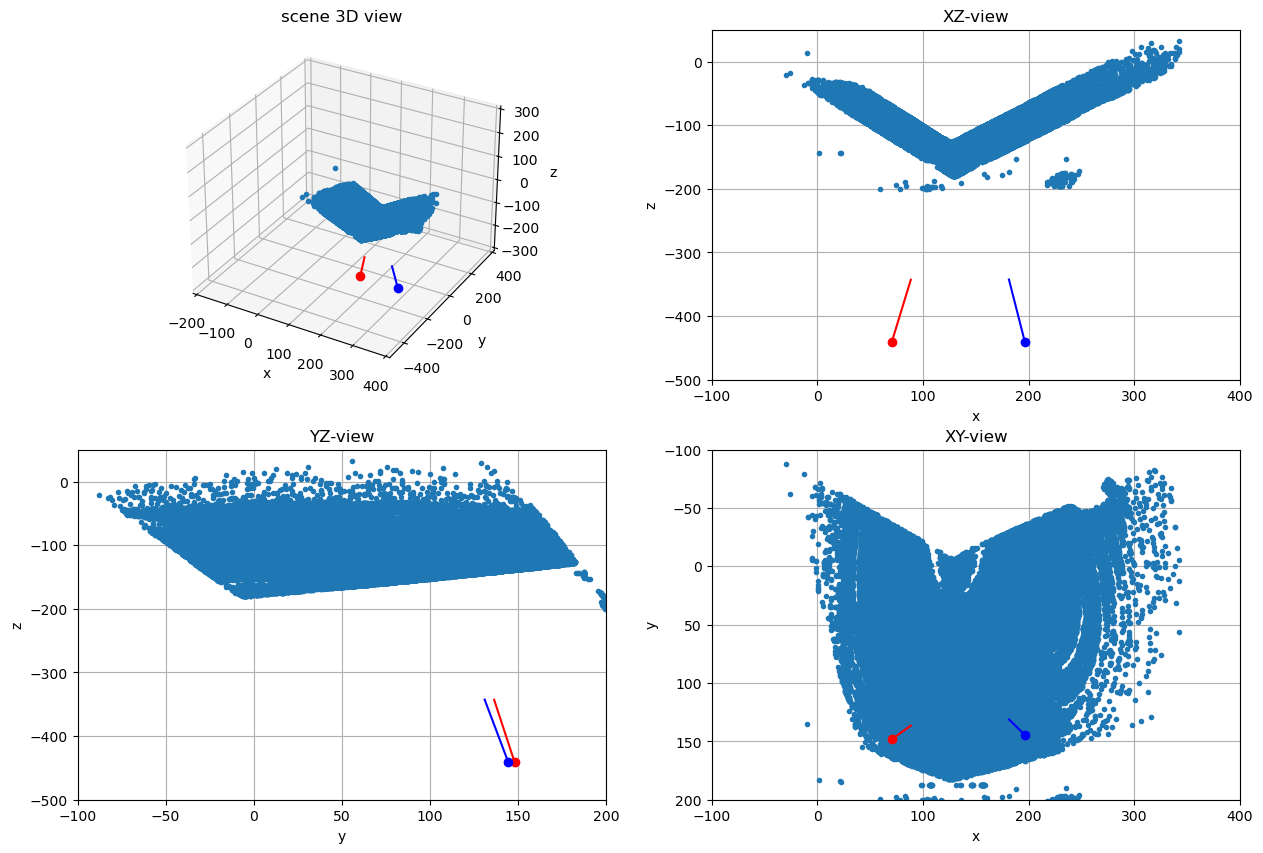

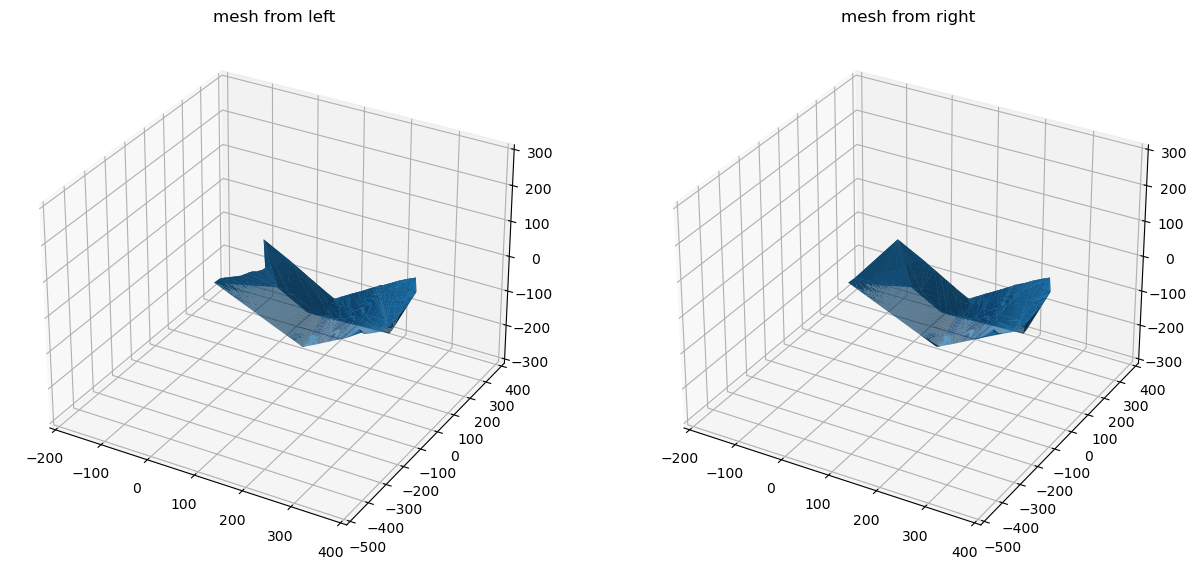

In [66]:
# vis code goes here

# generate coordinates of a line segment running from the center of the camera to 3 units in front of the camera
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,100]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,100]]).T))

# 3D plot showing cameras and points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
ax.set_xlim3d([-200,400])
ax.set_ylim3d([-500,400])
ax.set_zlim3d([-300,300])
visutils.label_axes(ax)
plt.title('scene 3D view')

# 2D view of the XZ axis
ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.axis([-100, 400, -500, 50])
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

# 2D view of the YZ axis
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.axis([-100, 200, -500, 50])
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

# 2D view of the XY axis
ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.axis([-100, 400, 200, -100])
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')


fig = plt.figure()
ax = fig.add_subplot(1,2,1,projection='3d')
tri=Delaunay(pts2L.T)
ax.plot_trisurf(pts3[0,:], pts3[1,:], pts3[2,:], triangles=tri.simplices)
ax.set_xlim3d([-200,400])
ax.set_ylim3d([-500,400])
ax.set_zlim3d([-300,300])
plt.title("mesh from left")


ax = fig.add_subplot(1,2,2,projection='3d')
tri=Delaunay(pts2R.T)
ax.plot_trisurf(pts3[0,:], pts3[1,:], pts3[2,:], triangles=tri.simplices)
ax.set_xlim3d([-200,400])
ax.set_ylim3d([-500,400])
ax.set_zlim3d([-300,300])
plt.title("mesh from right")

2 )
3 )